In [19]:
import pandas as pd
import urllib.request
import datetime as dt
import requests
import os
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from haversine import haversine, Unit
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import pytz
from sklearn.metrics import accuracy_score
import numpy as np
from prettytable import PrettyTable
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import glob
from statistics import mean

from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from numpy import mean, std
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from scipy.stats import zscore
import lightgbm as lgb

pd.set_option('display.max_columns', None)
p = print

## 1) Read in the Weather Data

In [2]:
# definte the processed and raw data directories
processed_data_dir = "../../data/processed/weather/"
raw_data_dir = "../../data/raw/"

In [3]:
weather_df = pd.read_csv(os.path.join(raw_data_dir, "weather_data", "weather_vectors_intrapolated.csv"))

In [4]:
weather_df.head()
# weather_df.shape

,image_name,air_temp_set_1,relative_humidity_set_1,wind_speed_set_1,wind_gust_set_1,wind_direction_set_1,dew_point_temperature_set_1d,u,v,fire_name
0,20190813_Topanga_69bravo-n-mobo/1565728842_-02400,-0.24240,0.29580,-1.43280,-1.37160,-0.495405,0.27720,-0.801122,0.283772,20190813_Topanga_69bravo-n-mobo
1,20190813_Topanga_69bravo-n-mobo/1565728902_-02340,-0.24678,0.29886,-1.42254,-1.38012,-0.489574,0.27522,-0.805174,0.279306,20190813_Topanga_69bravo-n-mobo
2,20190813_Topanga_69bravo-n-mobo/1565728962_-02280,-0.25116,0.30192,-1.41228,-1.38864,-0.483743,0.27324,-0.809226,0.274841,20190813_Topanga_69bravo-n-mobo
3,20190813_Topanga_69bravo-n-mobo/1565729022_-02220,-0.25554,0.30498,-1.40202,-1.39716,-0.477912,0.27126,-0.813278,0.270375,20190813_Topanga_69bravo-n-mobo
4,20190813_Topanga_69bravo-n-mobo/1565729082_-02160,-0.25992,0.30804,-1.39176,-1.40568,-0.472081,0.26928,-0.817330,0.265910,20190813_Topanga_69bravo-n-mobo


In [5]:
# read in camera metadata
# camera_metadata_df = pd.read_csv("../../data/processed/camera_metadata_hpwren.csv")
# read in camera metadata
camera_metadata_df = pd.read_csv("../../data/processed/camera_image_id_mappings.csv")
# camera_metadata_df

## GOES data

In [ ]:
# processed_data_dir = "../../data/processed/wfabba"
# processed_data_dir = "../../data/processed/wfabba_sliding/"
# processed_data_dir = "../../data/processed/wfabba_sliding_window_nearest_20min/"
processed_data_dir = "../../data/processed/wfabba_sliding_window_new_data/"
# processed_data_dir = "../../data/processed/wfabba_sliding_window_nearest_without_code_15/"
csv_suffix = "_all_hard_voting_35_window_20.csv"
# csv_suffix = "_all_hard_voting_35.csv"

csv_files = glob.glob(os.path.join(processed_data_dir, f"*{csv_suffix}"))
  
master_df = pd.DataFrame()
    
# loop over the list of csv files
for f in csv_files:
    df = pd.read_csv(f)
    df["file"] = f
    master_df = pd.concat([master_df, df])
    
master_df = master_df.reset_index()
master_df = master_df.drop(columns=["index", "Unnamed: 0"])
# master_df
master_df = master_df.rename(columns={"image_pred":"smokeynet_pred", "final_pred":"majority_vote_pred"})
# master_df
# get only the test data
master_copy_df = master_df[master_df["type"] == "test"].copy()
valid_copy_df = master_df[master_df["type"] == "valid"].copy()

# if either one of the 2 has code 15, let it remain in the df
condition = ((~master_copy_df["image_gt"].isna()) 
            # & (master_copy_df["WFABBA_GOES16_Code"] != 15) 
            # & (master_copy_df["WFABBA_GOES17_Code"] != 15)
)
valid_condition = ((~valid_copy_df["image_gt"].isna()) 
            # & (master_copy_df["WFABBA_GOES16_Code"] != 15) 
            # & (master_copy_df["WFABBA_GOES17_Code"] != 15)
)

# Calculate the baseline accuracies of the individual models and the hard vote ensemble
image_labels = master_copy_df[condition]["image_gt"]
smokeynet_preds = master_copy_df[condition]["smokeynet_pred"]
goes16_preds = master_copy_df[condition]["goes16_pred"]
goes17_preds = master_copy_df[condition]["goes17_pred"]
hard_vote_ensemble_preds = master_copy_df[condition]["majority_vote_pred"]

## Match Time DF with SmokeyNet

In [6]:
#Create dataframe for every minute of specified time period
times = []
start = datetime(2019, 6 , 1, 0, 0, 0, 0, pytz.UTC)
end = datetime(2021, 7, 11, 23, 59, 0, 0, pytz.UTC)

while start <= end:
    times.append(start)
    start = start + timedelta(minutes = 1)

minutes_df = pd.DataFrame(times, columns = ["timestamp"])
# minutes_df

In [175]:
# # Create training SmokeyNet df
# # df_test = pd.read_json(raw_data_dir + "smokeynet_test.json", orient="index").reset_index().rename(columns={"index":"filepath"})
# header = ['index', 'image_pred', 'image_prob', 'image_loss']
# # df_train = pd.read_csv("../../data/raw/smokeynet_outputs/image_preds_train.csv", names=header).rename(columns={"index":"filepath"})
# # df_test = pd.read_csv("../../data/raw/smokeynet_outputs/test_paper_baseline_version4_last_model_image_preds.csv", names=header).rename(columns={"index":"filepath"})
# df_train["type"] = "train"
# # df_test

In [7]:
# Create testing SmokeyNet df
# df_test = pd.read_json(raw_data_dir + "smokeynet_test.json", orient="index").reset_index().rename(columns={"index":"filepath"})
header = ['index', 'image_pred', 'image_prob', 'image_loss']
# df_test = pd.read_csv("../../data/raw/smokeynet_outputs/image_preds_test.csv", names=header).rename(columns={"index":"filepath"})
df_test = pd.read_csv("../../data/raw/smokeynet_outputs/image_preds_test_new_split.csv", names=header).rename(columns={"index":"filepath"})
# df_test = pd.read_csv("../../data/raw/smokeynet_outputs/test_paper_baseline_version4_last_model_image_preds.csv", names=header).rename(columns={"index":"filepath"})
df_test["type"] = "test"
# df_test

In [8]:
#Create validating SmokeyNet df
# df_valid = pd.read_json(raw_data_dir + "smokeynet_valid.json", orient="index").reset_index().rename(columns={"index":"filepath"})
header = ['index', 'image_pred', 'image_prob']
# df_valid = pd.read_csv("../../data/raw/smokeynet_outputs/image_preds_valid.csv", names=header).rename(columns={"index":"filepath"})
df_valid = pd.read_csv("../../data/raw/smokeynet_outputs/image_preds_val_new_split.csv", names=header).rename(columns={"index":"filepath"})
# df_valid = pd.read_csv("../../data/raw/smokeynet_outputs/val_paper_baseline_version4_last_model_image_preds.csv", names=header).rename(columns={"index":"filepath"})
df_valid["type"] = "valid"
# df_valid

In [9]:
#Join the SmokeyNet DFs together. For now just joining validation and test DFs
# df_labels = pd.concat([df_train, df_valid]).reset_index().drop(columns = ["index"])
# df_labels = pd.concat([df_test, df_valid]).reset_index().drop(columns = ["index"])
# df_labels
df_labels = df_valid.copy()

In [179]:
df_labels.columns

Index(['filepath', 'image_pred', 'image_prob', 'image_loss', 'type'], dtype='object')

In [180]:
df_labels

,filepath,image_pred,image_prob,image_loss,type
0,20160722_FIRE_mw-e-mobo-c/1469220721_-02400,0,0.10,NaN,train
1,20160722_FIRE_mw-e-mobo-c/1469220781_-02340,0,0.09,NaN,train
2,20160722_FIRE_mw-e-mobo-c/1469220841_-02280,0,0.10,NaN,train
3,20160722_FIRE_mw-e-mobo-c/1469220901_-02220,0,0.10,NaN,train
4,20160722_FIRE_mw-e-mobo-c/1469220961_-02160,0,0.08,NaN,train
...,...,...,...,...,...
16317,20180806_FIRE_mg-s-mobo-c/1533578618_+02160,1,1.00,NaN,valid
16318,20180806_FIRE_mg-s-mobo-c/1533578678_+02220,1,1.00,NaN,valid
16319,20180806_FIRE_mg-s-mobo-c/1533578738_+02280,1,1.00,NaN,valid
16320,20180806_FIRE_mg-s-mobo-c/1533578798_+02340,1,1.00,NaN,valid


In [10]:
df_labels['camera_name'] = df_labels.filepath.str.split("/").str[0]
df_valid['camera_name'] = df_valid.filepath.str.split("/").str[0]
df_test['camera_name'] = df_test.filepath.str.split("/").str[0]

In [11]:
def get_ground_truth_label(image_name):
    """Description: Returns 1 if image_name has a + in it (ie. is a positive) or 0 otherwise"""
    ground_truth_label = 1 if "+" in image_name else 0
    return ground_truth_label

df_labels['image_gt'] = df_labels.filepath.apply(get_ground_truth_label)
df_valid['image_gt'] = df_valid.filepath.apply(get_ground_truth_label)
df_test['image_gt'] = df_test.filepath.apply(get_ground_truth_label)

In [12]:
accuracy_score(df_test['image_gt'], df_test['image_pred'])
df_test.shape

(4798, 7)

In [106]:
df_labels.head()

,filepath,image_pred,image_prob,image_loss,type,camera_name,image_gt
0,20160722_FIRE_mw-e-mobo-c/1469220721_-02400,0,0.10,NaN,train,20160722_FIRE_mw-e-mobo-c,0
1,20160722_FIRE_mw-e-mobo-c/1469220781_-02340,0,0.09,NaN,train,20160722_FIRE_mw-e-mobo-c,0
2,20160722_FIRE_mw-e-mobo-c/1469220841_-02280,0,0.10,NaN,train,20160722_FIRE_mw-e-mobo-c,0
3,20160722_FIRE_mw-e-mobo-c/1469220901_-02220,0,0.10,NaN,train,20160722_FIRE_mw-e-mobo-c,0
4,20160722_FIRE_mw-e-mobo-c/1469220961_-02160,0,0.08,NaN,train,20160722_FIRE_mw-e-mobo-c,0


In [13]:
# set the date and year columns
df_labels["date"] = df_labels["camera_name"].str.split("_", n=1, expand=True)[0]
df_labels["year"] = df_labels["date"].str[:4]
df_labels["date"] = pd.to_datetime(df_labels["date"])
# df_labels

# keeping only entries from 2019-06-01 onwards
# df_labels_filtered = df_labels[df_labels["date"] >= "2019-06-01"].reset_index().drop(columns=["index"])
df_labels_filtered = df_labels.reset_index().drop(columns=["index"])
# df_labels_filtered

#create time, datetime, event_name, camera_name attributes
df_labels_filtered["time"] = df_labels_filtered["filepath"].str.split("/").str[1]
df_labels_filtered["time"] = df_labels_filtered["time"].str.split("_").str[0]
df_labels_filtered["datetime"] = pd.to_datetime(df_labels_filtered["time"], unit="s", origin="unix", utc=True)
df_labels_filtered["event_name"] = df_labels_filtered["filepath"].str.split("/").str[0]
df_labels_filtered["camera_name"] = df_labels_filtered["camera_name"].str.split("_").str[-1]
# df_labels_filtered

# join SmokeyNet data with camera metadata
# df_labels_filtered = df_labels_filtered.merge(camera_metadata_df, left_on="camera_name", right_on="image_id", how="left")
# df_labels_filtered

# convert joined SmokeyNet-camera metadata dataframe's coordinates from EPSG 4326 to EPSG 3310
# coords = [Point(xy) for xy in zip(df_labels_filtered['long'], df_labels_filtered['lat'])]
# df_labels_filtered = GeoDataFrame(df_labels_filtered, crs = "EPSG:4326", geometry = coords) 
# df_labels_filtered = df_labels_filtered.to_crs('EPSG:3310')
# df_labels_filtered

In [14]:
# set the date and year columns
df_test["date"] = df_test["camera_name"].str.split("_", n=1, expand=True)[0]
df_test["year"] = df_test["date"].str[:4]
df_test["date"] = pd.to_datetime(df_test["date"])
# df_test

# keeping only entries from 2019-06-01 onwards
# df_test_filtered = df_test[df_test["date"] >= "2019-06-01"].reset_index().drop(columns=["index"])
df_test_filtered = df_test.reset_index().drop(columns=["index"])
# df_test_filtered

#create time, datetime, event_name, camera_name attributes
df_test_filtered["time"] = df_test_filtered["filepath"].str.split("/").str[1]
df_test_filtered["time"] = df_test_filtered["time"].str.split("_").str[0]
df_test_filtered["datetime"] = pd.to_datetime(df_test_filtered["time"], unit="s", origin="unix", utc=True)
df_test_filtered["event_name"] = df_test_filtered["filepath"].str.split("/").str[0]
df_test_filtered["camera_name"] = df_test_filtered["camera_name"].str.split("_").str[-1]
# df_test_filtered

# join SmokeyNet data with camera metadata
# df_test_filtered = df_test_filtered.merge(camera_metadata_df, left_on="camera_name", right_on="image_id", how="left")
# df_test_filtered

# convert joined SmokeyNet-camera metadata dataframe's coordinates from EPSG 4326 to EPSG 3310
# coords = [Point(xy) for xy in zip(df_test_filtered['long'], df_test_filtered['lat'])]
# df_test_filtered = GeoDataFrame(df_test_filtered, crs = "EPSG:4326", geometry = coords) 
# df_test_filtered = df_test_filtered.to_crs('EPSG:3310')
# df_test_filtered

In [16]:
p (df_labels_filtered.shape)
df_labels_filtered.head()

(16322, 12)


,filepath,image_pred,image_prob,image_loss,type,camera_name,image_gt,date,year,time,datetime,event_name
0,20160722_FIRE_mw-e-mobo-c/1469220721_-02400,0,0.10,NaN,train,mw-e-mobo-c,0,2016-07-22,2016,1469220721,2016-07-22 20:52:01+00:00,20160722_FIRE_mw-e-mobo-c
1,20160722_FIRE_mw-e-mobo-c/1469220781_-02340,0,0.09,NaN,train,mw-e-mobo-c,0,2016-07-22,2016,1469220781,2016-07-22 20:53:01+00:00,20160722_FIRE_mw-e-mobo-c
2,20160722_FIRE_mw-e-mobo-c/1469220841_-02280,0,0.10,NaN,train,mw-e-mobo-c,0,2016-07-22,2016,1469220841,2016-07-22 20:54:01+00:00,20160722_FIRE_mw-e-mobo-c
3,20160722_FIRE_mw-e-mobo-c/1469220901_-02220,0,0.10,NaN,train,mw-e-mobo-c,0,2016-07-22,2016,1469220901,2016-07-22 20:55:01+00:00,20160722_FIRE_mw-e-mobo-c
4,20160722_FIRE_mw-e-mobo-c/1469220961_-02160,0,0.08,NaN,train,mw-e-mobo-c,0,2016-07-22,2016,1469220961,2016-07-22 20:56:01+00:00,20160722_FIRE_mw-e-mobo-c


## Join SmokeyNet with Weather Data

In [15]:
df_smokey_and_weather = df_labels_filtered.merge(weather_df, left_on="filepath", right_on="image_name", how="inner")
df_test_smokey_and_weather = df_test_filtered.merge(weather_df, left_on="filepath", right_on="image_name", how="inner")

In [16]:
p (df_smokey_and_weather.loc[(df_smokey_and_weather.filepath == df_smokey_and_weather.image_name)].shape)
df_smokey_and_weather.loc[(df_smokey_and_weather.filepath != df_smokey_and_weather.image_name)].head()

p (df_test_smokey_and_weather.shape, df_test_filtered.shape)

(4894, 21)
(4798, 22) (4798, 12)


In [188]:
p (df_smokey_and_weather.shape)
p (weather_df.shape)
df_smokey_and_weather.head()

(15196, 22)
(19995, 10)


,filepath,image_pred,image_prob,image_loss,type,camera_name,image_gt,date,year,time,datetime,event_name,image_name,air_temp_set_1,relative_humidity_set_1,wind_speed_set_1,wind_gust_set_1,wind_direction_set_1,dew_point_temperature_set_1d,u,v,fire_name
0,20160722_FIRE_mw-e-mobo-c/1469220721_-02400,0,0.10,NaN,train,mw-e-mobo-c,0,2016-07-22,2016,1469220721,2016-07-22 20:52:01+00:00,20160722_FIRE_mw-e-mobo-c,20160722_FIRE_mw-e-mobo-c/1469220721_-02400,2.3790,-2.407800,0.1956,-0.027600,0.779526,-2.1906,1.061387,-0.138761,20160722_FIRE_mw-e-mobo-c
1,20160722_FIRE_mw-e-mobo-c/1469220781_-02340,0,0.09,NaN,train,mw-e-mobo-c,0,2016-07-22,2016,1469220781,2016-07-22 20:53:01+00:00,20160722_FIRE_mw-e-mobo-c,20160722_FIRE_mw-e-mobo-c/1469220781_-02340,2.3796,-2.393325,0.1431,-0.008625,0.775922,-2.1954,1.052444,-0.154334,20160722_FIRE_mw-e-mobo-c
2,20160722_FIRE_mw-e-mobo-c/1469220841_-02280,0,0.10,NaN,train,mw-e-mobo-c,0,2016-07-22,2016,1469220841,2016-07-22 20:54:01+00:00,20160722_FIRE_mw-e-mobo-c,20160722_FIRE_mw-e-mobo-c/1469220841_-02280,2.3802,-2.378850,0.0906,0.010350,0.772317,-2.2002,1.043501,-0.169907,20160722_FIRE_mw-e-mobo-c
3,20160722_FIRE_mw-e-mobo-c/1469220901_-02220,0,0.10,NaN,train,mw-e-mobo-c,0,2016-07-22,2016,1469220901,2016-07-22 20:55:01+00:00,20160722_FIRE_mw-e-mobo-c,20160722_FIRE_mw-e-mobo-c/1469220901_-02220,2.3808,-2.364375,0.0381,0.029325,0.768713,-2.2050,1.034558,-0.185480,20160722_FIRE_mw-e-mobo-c
4,20160722_FIRE_mw-e-mobo-c/1469220961_-02160,0,0.08,NaN,train,mw-e-mobo-c,0,2016-07-22,2016,1469220961,2016-07-22 20:56:01+00:00,20160722_FIRE_mw-e-mobo-c,20160722_FIRE_mw-e-mobo-c/1469220961_-02160,2.3814,-2.349900,-0.0144,0.048300,0.765108,-2.2098,1.025615,-0.201053,20160722_FIRE_mw-e-mobo-c


In [20]:
len([x for x,y in dict(df_smokey_and_weather.filepath.value_counts()).items() if y > 1])
# df_smokey_and_weather.loc[df_smokey_and_weather.filepath == "20190801_Caliente_om-w-mobo/1564683161_-02040"]
# weather_df.loc[weather_df.image_name == "20190801_Caliente_om-w-mobo/1564683161_-02040"]

0

## Create test splits based on fires

In [63]:
df_combined = pd.concat([
       df_smokey_and_weather.loc[df_smokey_and_weather["type"] != "train"],
       df_test_smokey_and_weather
]).reset_index().drop(columns = ["index"])
# df_combined = df_test_smokey_and_weather.copy()
# df_combined = df_smokey_and_weather.copy()
# df_combined["image_loss"] = 1

In [64]:
def train(scale = 1, multiplication_factor = 1, repetitions = 10):
    xgb = []
    smokey = []
    for i in range(repetitions):

        # fires = df_combined.event_name.unique()
        fires = df_combined.event_name.unique()

        train_fires, test_fires = train_test_split(
            fires,
            test_size=0.2
        )

        train_df = df_combined.loc[(df_combined["event_name"].isin(train_fires))].drop("image_loss", axis='columns').sample(frac=1)
        # train_df = df_combined.filter(lambda x: x if x["event_name"] in train_fires)
        test_df = df_combined.loc[(df_combined["event_name"].isin(test_fires))].drop("image_loss", axis='columns').sample(frac=1)

        weather_cols = weather_df.columns[1:-1].to_list()
        train_df[weather_cols] = train_df[weather_cols] * multiplication_factor

        feature_columns = ['image_prob', 'air_temp_set_1', 'relative_humidity_set_1',
            'wind_speed_set_1', 'wind_gust_set_1', 'wind_direction_set_1',
            'dew_point_temperature_set_1d', 'u', 'v']
        gt_label = 'image_gt'

        for j in range(scale-1):
            train_df = train_df.merge(weather_df, left_on="filepath", right_on="image_name", how="inner", suffixes=(None, f"_{j}"))
            test_df = test_df.merge(weather_df, left_on="filepath", right_on="image_name", how="inner", suffixes=(None, f"_{j}"))
            # drop_cols = [x for x in train_df.columns if "fire_name" in x or "image_name" in x]
            # train_df = train_df.drop(drop_cols, axis="columns")
            feature_columns += [f"{x}_{j}" for x in weather_cols]

        x_train = train_df[feature_columns].astype(float)
        y_train = train_df['image_gt'].astype(int)
        x_test = test_df[feature_columns].astype(float)
        y_test = test_df['image_gt'].astype(int)

        model = XGBClassifier(use_label_encoder=False)
        # model = XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.05, max_depth=8, subsample=0.5,
        #                             tree_method="auto", reg_lambda=1, grow_policy="depthwise")
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        # p (f"Accuracy XGB = {accuracy}")
        xgb.append(accuracy)
        smokeynet_pred = x_test['image_prob'].apply(lambda x: 0 if x < 0.5 else 1).tolist()
        accuracy = accuracy_score(y_test, smokeynet_pred)
        # p (f"Accuracy only smokey = {accuracy}")
        smokey.append(accuracy)
        # p (len(y_test), len([x for x in y_test if x == 1]))
        p (len(y_train), len(y_test))
    print (f"Mean XGB accuracy: {mean(xgb)}")
    print (f"Mean Smokey accuracy: {mean(smokey)}")

In [65]:
scale = 1
multiplication_factor = 1

train(scale, multiplication_factor, 10)

# print (help(ConfusionMatrixDisplay))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
# fig.suptitle('Confusion Matrices')
# plt.figure(figsize=[10,40])

# sn.heatmap(confusion_matrix(y_test, smokeynet_pred), annot=True, fmt='g', ax=ax1)
# sn.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax2)

# # labels, title and ticks
# ax1.set_xlabel('Predicted labels')
# ax1.set_ylabel('True labels') 
# ax1.set_title('SmokeyNet')
# ax2.set_xlabel('Predicted labels')
# ax2.set_ylabel('True labels') 
# ax2.set_title('XGB')

7713 1979
7733 1959
7723 1969
7721 1971
7763 1929
7733 1959
7784 1908
7746 1946
7721 1971
7760 1932
Mean XGB accuracy: 0.7562976277740583
Mean Smokey accuracy: 0.8104620490255199


In [72]:
scale = 1
multiplication_factor = 1
repetitions = 15

xgb = []
smokey = []

models = {
    'logistic': LogisticRegression(),
    'sgd_squared_hinge': SGDClassifier(loss='squared_hinge', learning_rate='adaptive', eta0=0.0001),
    'sgd_hinge': SGDClassifier(loss='hinge', learning_rate='adaptive', eta0=0.0001, max_iter=5000),
    'sgd_hinge_lr_0.001': SGDClassifier(loss='hinge', learning_rate='adaptive', eta0=0.005, max_iter=5000),
    'sgd_hinge_shuffle_False': SGDClassifier(loss='hinge', shuffle=False),
    'svm': svm.SVC(),
    'adaboost': AdaBoostClassifier(learning_rate=0.0001),
    'adaboost_lr_0.001': AdaBoostClassifier(learning_rate=0.001),
    'k_nearest_7': KNeighborsClassifier(n_neighbors=7),
    'k_nearest_5': KNeighborsClassifier(n_neighbors=5),
    'k_nearest_10': KNeighborsClassifier(n_neighbors=10),
    'xgboost': XGBClassifier(use_label_encoder=False),
    'xgboost_tuned': XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.05, max_depth=6, subsample=0.5,
                            tree_method="gpu_hist", sampling_method="gradient_based", reg_lambda=1, 
                            gamma=0.3), #, objective="reg:squaredlogerror", eval_metric="rmsle", grow_policy="lossguide"
    'lightgbm_gbdt': lgb.LGBMClassifier(learning_rate=0.05,max_depth=-5,boosting_type='gbdt'),
    # 'lightgbm_dart': lgb.LGBMClassifier(learning_rate=0.001,max_depth=-5,boosting_type='dart'),
    # 'lightgbm_goss': lgb.LGBMClassifier(learning_rate=0.001,max_depth=-5,boosting_type='goss')
}

# model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
# model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
#           verbose=20,eval_metric='logloss')

from collections import defaultdict
results = defaultdict(list)

for i in range(repetitions):

    # fires = df_combined.event_name.unique()
    fires = df_combined.event_name.unique()

    train_fires, test_fires = train_test_split(
        fires,
        test_size=0.2
    )

    train_df = df_combined.loc[(df_combined["event_name"].isin(train_fires))].sample(frac=1)
    # train_df = df_combined.filter(lambda x: x if x["event_name"] in train_fires)
    test_df = df_combined.loc[(df_combined["event_name"].isin(test_fires))].sample(frac=1)

    weather_cols = weather_df.columns[1:-1].to_list()
    train_df[weather_cols] = train_df[weather_cols] * multiplication_factor

    feature_columns = ['image_prob', 'air_temp_set_1', 'relative_humidity_set_1',
        'wind_speed_set_1', 'wind_gust_set_1', 'wind_direction_set_1',
        'dew_point_temperature_set_1d', 'u', 'v']
    gt_label = 'image_gt'

    for j in range(scale-1):
        train_df = train_df.merge(weather_df, left_on="filepath", right_on="image_name", how="inner", suffixes=(None, f"_{j}"))
        test_df = test_df.merge(weather_df, left_on="filepath", right_on="image_name", how="inner", suffixes=(None, f"_{j}"))
        # drop_cols = [x for x in train_df.columns if "fire_name" in x or "image_name" in x]
        # train_df = train_df.drop(drop_cols, axis="columns")
        feature_columns += [f"{x}_{j}" for x in weather_cols]

    x_train = train_df[feature_columns].astype(float)
    y_train = train_df['image_gt'].astype(int)
    x_test = test_df[feature_columns].astype(float)
    y_test = test_df['image_gt'].astype(int)

    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        xgb_accuracy = accuracy_score(y_test, y_pred)
        # p (f"Accuracy XGB = {accuracy}")
        smokeynet_pred = x_test['image_prob'].apply(lambda x: 0 if x < 0.5 else 1).tolist()
        smokey_accuracy = accuracy_score(y_test, smokeynet_pred)
        # p (f"Accuracy only smokey = {accuracy}")
        results[name].append((xgb_accuracy, smokey_accuracy))

for name in models.keys():
    # print (results[name])
    print (f"Model: {name}, Mean Model: {mean([x[0] for x in results[name]])}, Mean Smokey: {mean([x[1] for x in results[name]])}")

Model: logistic, Mean Model: 0.7942618354715871, Mean Smokey: 0.8073052883585752
Model: sgd_squared_hinge, Mean Model: 0.7991417219131699, Mean Smokey: 0.8073052883585752
Model: sgd_hinge, Mean Model: 0.8082942495304952, Mean Smokey: 0.8073052883585752
Model: sgd_hinge_lr_0.001, Mean Model: 0.807711596203067, Mean Smokey: 0.8073052883585752
Model: sgd_hinge_shuffle_False, Mean Model: 0.803362138562975, Mean Smokey: 0.8073052883585752
Model: svm, Mean Model: 0.7417697476478042, Mean Smokey: 0.8073052883585752
Model: adaboost, Mean Model: 0.8072176581968513, Mean Smokey: 0.8073052883585752
Model: adaboost_lr_0.001, Mean Model: 0.8072850322915119, Mean Smokey: 0.8073052883585752
Model: k_nearest_7, Mean Model: 0.6834479035213764, Mean Smokey: 0.8073052883585752
Model: k_nearest_5, Mean Model: 0.6744337461993474, Mean Smokey: 0.8073052883585752
Model: k_nearest_10, Mean Model: 0.6887124383580433, Mean Smokey: 0.8073052883585752
Model: xgboost, Mean Model: 0.7389876566426775, Mean Smokey: 0

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Confusion Matrices')
plt.figure(figsize=[10,40])

sn.heatmap(confusion_matrix(y_test, smokeynet_pred), annot=True, fmt='g', ax=ax1)
sn.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax2)

# labels, title and ticks
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels') 
ax1.set_title('SmokeyNet')
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels') 
ax2.set_title('XGB')

## Ensemble of SmokeyNet Probabilities with Weather Data

In [191]:
df_smokey_and_weather.columns

Index(['filepath', 'image_pred', 'image_prob', 'image_loss', 'type',
       'camera_name', 'image_gt', 'date', 'year', 'time', 'datetime',
       'event_name', 'image_name', 'air_temp_set_1', 'relative_humidity_set_1',
       'wind_speed_set_1', 'wind_gust_set_1', 'wind_direction_set_1',
       'dew_point_temperature_set_1d', 'u', 'v', 'fire_name'],
      dtype='object')

In [192]:
# EDA
# check for nulls post join, since left join
p (sum(df_smokey_and_weather.image_name.isna()))

# weather data is z-score normalized, check for nulls
p ([(col, sum(df_smokey_and_weather[col].isna())) for col in df_smokey_and_weather.columns])

0
[('filepath', 0), ('image_pred', 0), ('image_prob', 0), ('image_loss', 15196), ('type', 0), ('camera_name', 0), ('image_gt', 0), ('date', 0), ('year', 0), ('time', 0), ('datetime', 0), ('event_name', 0), ('image_name', 0), ('air_temp_set_1', 0), ('relative_humidity_set_1', 0), ('wind_speed_set_1', 0), ('wind_gust_set_1', 0), ('wind_direction_set_1', 0), ('dew_point_temperature_set_1d', 0), ('u', 0), ('v', 0), ('fire_name', 0)]


### Training + Validation Data

In [115]:
feature_columns = ['image_prob', 'air_temp_set_1', 'relative_humidity_set_1',
       'wind_speed_set_1', 'wind_gust_set_1', 'wind_direction_set_1',
       'dew_point_temperature_set_1d', 'u', 'v']
gt_label = 'image_gt'

# Using SmokeyNet train + validation data to train using cross validation
x = df_smokey_and_weather[feature_columns].astype(float)
y = df_smokey_and_weather['image_gt'].astype(int)

models = {
    'logistic': LogisticRegression(),
    'sgd_squared_hinge': SGDClassifier(loss='squared_hinge', learning_rate='adaptive', eta0=0.0001),
    'sgd_hinge': SGDClassifier(loss='hinge'),
    'svm': svm.SVC(),
    'adaboost': AdaBoostClassifier(learning_rate=0.0001),
    'k_nearest_7': KNeighborsClassifier(n_neighbors=7),
    'k_nearest_5': KNeighborsClassifier(n_neighbors=5),
    'k_nearest_10': KNeighborsClassifier(n_neighbors=10),
    'xgboost': XGBClassifier(use_label_encoder=False),
    # 'xgboost_tuned': XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.1, max_depth=8, subsample=0.7,
    #                         tree_method="auto", reg_lambda=1, grow_policy="depthwise", gamma=0),
    # 'xgboost_tuned': XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.05, max_depth=8, subsample=0.5,
    #                         tree_method="gpu_hist", sampling_method="gradient_based", reg_lambda=1, grow_policy="lossguide", 
    #                         gamma=0, objective="reg:squaredlogerror", eval_metric="rmsle")
}

results = {}

for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    # cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    results[name] = scores
    p ('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>logistic 0.917 (0.005)
>sgd_squared_hinge 0.918 (0.005)
>sgd_hinge 0.918 (0.004)
>svm 0.929 (0.005)
>adaboost 0.922 (0.005)
>k_nearest_7 0.978 (0.003)
>k_nearest_5 0.981 (0.003)
>k_nearest_10 0.973 (0.003)
>xgboost 0.984 (0.003)


### Validation + Testing Data

In [116]:
feature_columns = ['image_prob', 'air_temp_set_1', 'relative_humidity_set_1',
       'wind_speed_set_1', 'wind_gust_set_1', 'wind_direction_set_1',
       'dew_point_temperature_set_1d', 'u', 'v']
gt_label = 'image_gt'

# Using SmokeyNet train + validation data to train using cross validation
# x = df_smokey_and_weather[feature_columns].astype(float)
# y = df_smokey_and_weather['image_gt'].astype(int)
df_combined = pd.concat([
       df_smokey_and_weather.loc[df_smokey_and_weather["type"] != "train"],
       df_test_smokey_and_weather
]).reset_index().drop(columns = ["index"])

x = df_combined[feature_columns].astype(float)
y = df_combined['image_gt'].astype(int)

models = {
    'logistic': LogisticRegression(),
    'sgd_squared_hinge': SGDClassifier(loss='squared_hinge', learning_rate='adaptive', eta0=0.0001),
    'sgd_hinge': SGDClassifier(loss='hinge'),
    'svm': svm.SVC(),
    'adaboost': AdaBoostClassifier(learning_rate=0.0001),
    'k_nearest_7': KNeighborsClassifier(n_neighbors=7),
    'k_nearest_5': KNeighborsClassifier(n_neighbors=5),
    'k_nearest_10': KNeighborsClassifier(n_neighbors=10),
    'xgboost': XGBClassifier(use_label_encoder=False),
    # 'xgboost_tuned': XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.1, max_depth=8, subsample=0.7,
    #                         tree_method="auto", reg_lambda=1, grow_policy="depthwise", gamma=0),
    # 'xgboost_tuned': XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.05, max_depth=8, subsample=0.5,
    #                         tree_method="gpu_hist", sampling_method="gradient_based", reg_lambda=1, grow_policy="lossguide", 
    #                         gamma=0, objective="reg:squaredlogerror", eval_metric="rmsle")
}

results = {}

for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    # cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    results[name] = scores
    p ('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>logistic 0.820 (0.012)
>sgd_squared_hinge 0.820 (0.012)
>sgd_hinge 0.818 (0.013)
>svm 0.860 (0.011)
>adaboost 0.818 (0.013)
>k_nearest_7 0.959 (0.006)
>k_nearest_5 0.966 (0.006)
>k_nearest_10 0.947 (0.007)
>xgboost 0.973 (0.005)


## Using SmokeyNet training data for training and validation+testing data as test set

Accuracy XGB = 0.8019189105540081
Accuracy only smokey = 0.8184256680078407


Text(0.5, 1.0, 'XGB')

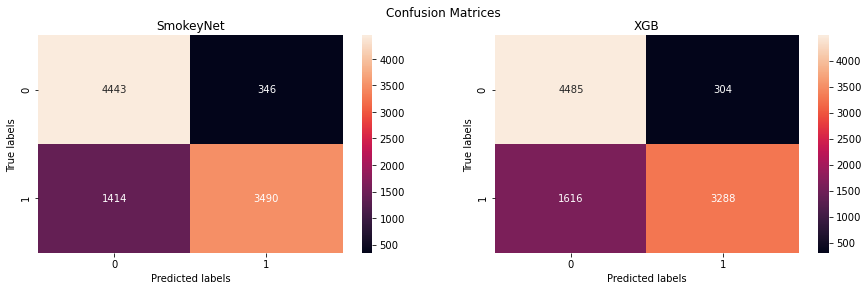

<Figure size 720x2880 with 0 Axes>

In [25]:
feature_columns = ['image_prob', 'air_temp_set_1', 'relative_humidity_set_1',
       'wind_speed_set_1', 'wind_gust_set_1', 'wind_direction_set_1',
       'dew_point_temperature_set_1d', 'u', 'v']
gt_label = 'image_gt'

# SmokeyNet training data used for training
x_train = df_smokey_and_weather.loc[df_smokey_and_weather["type"] == "train"][feature_columns].astype(float)
y_train = df_smokey_and_weather.loc[df_smokey_and_weather["type"] == "train"]['image_gt'].astype(int)
# SmokeyNet validation + testing data used for testing
# x_test = df_smokey_and_weather.loc[df_smokey_and_weather["type"] != "train"][feature_columns].astype(float)
# y_test = df_smokey_and_weather.loc[df_smokey_and_weather["type"] != "train"]['image_gt'].astype(int)
df_test_merged = pd.concat([
       df_smokey_and_weather.loc[df_smokey_and_weather["type"] != "train"],
       df_test_smokey_and_weather
]).reset_index().drop(columns = ["index"])
x_test = df_test_merged[feature_columns].astype(float)
y_test = df_test_merged['image_gt'].astype(float)

# x_train, x_test, y_train, y_test = train_test_split(
#     x,
#     y,
#     test_size=0.2
# )
model = XGBClassifier(use_label_encoder=False)
# model = XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.05, max_depth=8, subsample=0.5,
#                             tree_method="auto", reg_lambda=1, grow_policy="depthwise")
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
p (f"Accuracy XGB = {accuracy}")
smokeynet_pred = x_test['image_prob'].apply(lambda x: 0 if x < 0.5 else 1).tolist()
accuracy = accuracy_score(y_test, smokeynet_pred)
p (f"Accuracy only smokey = {accuracy}")

# print (help(ConfusionMatrixDisplay))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Confusion Matrices')
plt.figure(figsize=[10,40])

sn.heatmap(confusion_matrix(y_test, smokeynet_pred), annot=True, fmt='g', ax=ax1)
sn.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax2)

# labels, title and ticks
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels') 
ax1.set_title('SmokeyNet')
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels') 
ax2.set_title('XGB')

## Using SmokeyNet training + validation data for training and testing data for test

Accuracy XGB = 0.8170452177536986
Accuracy only smokey = 0.8360075015628256


Text(0.5, 1.0, 'XGB')

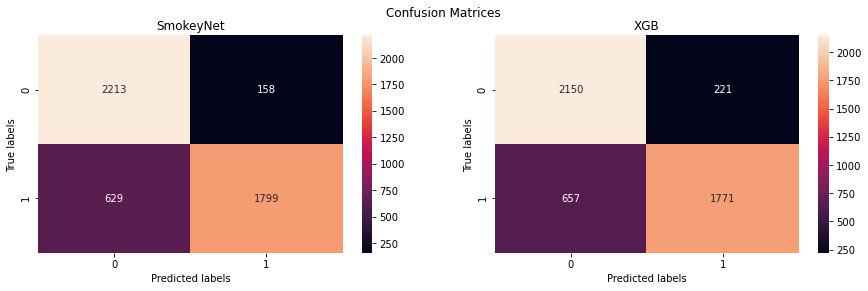

<Figure size 720x2880 with 0 Axes>

In [26]:
feature_columns = ['image_prob', 'air_temp_set_1', 'relative_humidity_set_1',
       'wind_speed_set_1', 'wind_gust_set_1', 'wind_direction_set_1',
       'dew_point_temperature_set_1d', 'u', 'v']
gt_label = 'image_gt'

# SmokeyNet training data used for training
x_train = df_smokey_and_weather[feature_columns].astype(float)
y_train = df_smokey_and_weather['image_gt'].astype(int)
# SmokeyNet validation + testing data used for testing
# x_test = df_smokey_and_weather.loc[df_smokey_and_weather["type"] != "train"][feature_columns].astype(float)
# y_test = df_smokey_and_weather.loc[df_smokey_and_weather["type"] != "train"]['image_gt'].astype(int)
x_test = df_test_smokey_and_weather[feature_columns].astype(float)
y_test = df_test_smokey_and_weather['image_gt'].astype(float)
# smokeynet_pred = df_test_smokey_and_weather['image_pred'].astype(float)

# x_train, x_test, y_train, y_test = train_test_split(
#     x,
#     y,
#     test_size=0.2
# )
model = XGBClassifier(use_label_encoder=False)
# model = XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.05, max_depth=8, subsample=0.5,
#                             tree_method="auto", reg_lambda=1, grow_policy="depthwise")
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
p (f"Accuracy XGB = {accuracy}")
smokeynet_pred = x_test['image_prob'].apply(lambda x: 0 if x < 0.5 else 1).tolist()
accuracy = accuracy_score(y_test, smokeynet_pred)
p (f"Accuracy only smokey = {accuracy}")

# print (help(ConfusionMatrixDisplay))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Confusion Matrices')
plt.figure(figsize=[10,40])

sn.heatmap(confusion_matrix(y_test, smokeynet_pred), annot=True, fmt='g', ax=ax1)
sn.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax2)

# labels, title and ticks
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels') 
ax1.set_title('SmokeyNet')
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels') 
ax2.set_title('XGB')

## Using SmokeyNet Validation data for training and Testing data for testing

Accuracy XGB = 0.759324859345697
Accuracy only smokey = 0.8360075015628256


Text(0.5, 1.0, 'XGB')

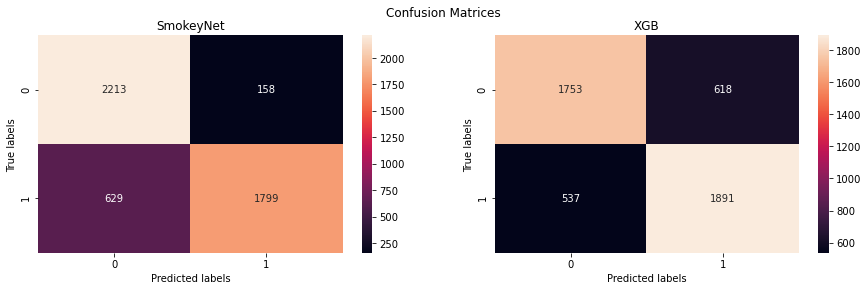

<Figure size 720x2880 with 0 Axes>

In [27]:
feature_columns = ['image_prob', 'air_temp_set_1', 'relative_humidity_set_1',
       'wind_speed_set_1', 'wind_gust_set_1', 'wind_direction_set_1',
       'dew_point_temperature_set_1d', 'u', 'v']
gt_label = 'image_gt'

# SmokeyNet validation + testing data used for testing
x_train = df_smokey_and_weather.loc[df_smokey_and_weather["type"] != "train"][feature_columns].astype(float)
y_train = df_smokey_and_weather.loc[df_smokey_and_weather["type"] != "train"]['image_gt'].astype(int)
x_test = df_test_smokey_and_weather[feature_columns].astype(float)
y_test = df_test_smokey_and_weather['image_gt'].astype(float)
# smokeynet_pred = df_test_smokey_and_weather['image_pred'].astype(float)

# x_train, x_test, y_train, y_test = train_test_split(
#     x,
#     y,
#     test_size=0.2
# )
model = XGBClassifier(use_label_encoder=False)
# model = XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.05, max_depth=8, subsample=0.5,
#                             tree_method="auto", reg_lambda=1, grow_policy="depthwise")
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
p (f"Accuracy XGB = {accuracy}")
smokeynet_pred = x_test['image_prob'].apply(lambda x: 0 if x < 0.5 else 1).tolist()
accuracy = accuracy_score(y_test, smokeynet_pred)
p (f"Accuracy only smokey = {accuracy}")

# print (help(ConfusionMatrixDisplay))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Confusion Matrices')
plt.figure(figsize=[10,40])

sn.heatmap(confusion_matrix(y_test, smokeynet_pred), annot=True, fmt='g', ax=ax1)
sn.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax2)

# labels, title and ticks
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels') 
ax1.set_title('SmokeyNet')
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels') 
ax2.set_title('XGB')

## Using SmokeyNet validation + testing data for training and testing

Accuracy XGB = 0.9700876740587931
Accuracy only smokey = 0.7968024755028366
(7753, 9) (1939, 9)


Text(0.5, 1.0, 'XGB')

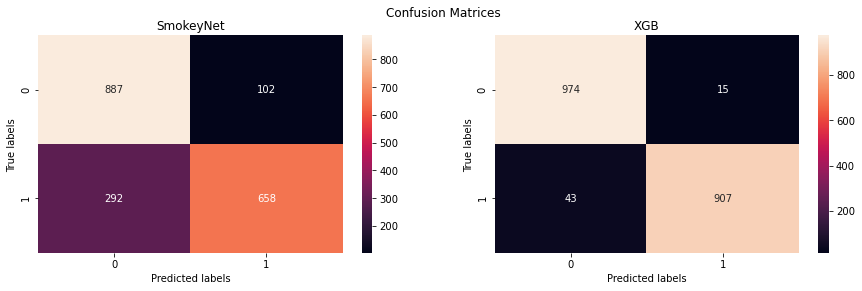

<Figure size 720x2880 with 0 Axes>

In [36]:
feature_columns = ['image_prob', 'air_temp_set_1', 'relative_humidity_set_1',
       'wind_speed_set_1', 'wind_gust_set_1', 'wind_direction_set_1',
       'dew_point_temperature_set_1d', 'u', 'v']
gt_label = 'image_gt'

df_combined = pd.concat([
       df_smokey_and_weather.loc[df_smokey_and_weather["type"] != "train"],
       df_test_smokey_and_weather
]).reset_index().drop(columns = ["index"])

x = df_combined[feature_columns].astype(float)
y = df_combined['image_gt'].astype(int)

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2
)
model = XGBClassifier(use_label_encoder=False)
# model = XGBClassifier(use_label_encoder=False, booster="gbtree", eta=0.05, max_depth=8, subsample=0.5,
#                             tree_method="auto", reg_lambda=1, grow_policy="depthwise")
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
p (f"Accuracy XGB = {accuracy}")
smokeynet_pred = x_test['image_prob'].apply(lambda x: 0 if x < 0.5 else 1).tolist()
accuracy = accuracy_score(y_test, smokeynet_pred)
p (f"Accuracy only smokey = {accuracy}")
p (x_train.shape, x_test.shape)

# print (help(ConfusionMatrixDisplay))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Confusion Matrices')
plt.figure(figsize=[10,40])

sn.heatmap(confusion_matrix(y_test, smokeynet_pred), annot=True, fmt='g', ax=ax1)
sn.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax2)

# labels, title and ticks
ax1.set_xlabel('Predicted labels')
ax1.set_ylabel('True labels') 
ax1.set_title('SmokeyNet')
ax2.set_xlabel('Predicted labels')
ax2.set_ylabel('True labels') 
ax2.set_title('XGB')

In [195]:
p (len([1 for x in y_test if x == 1]))
len(y_test)

986


1939

SmokeyNet -> Train, val  test
|
(val, test) + weather -> XGB

In [58]:
test_df = x_test.copy()
test_df['image_gt'] = y_test
test_df = test_df.reset_index()

# these indices have image_pred = 1
blah = test_df.loc[test_df.image_prob >= 0.5].index
# fetch corresponding values from the xgb y_pred list
duh = [y_pred[i] for i in blah]

# how many zeros in duh?
sum([1 if i == 0 else 0 for i in duh])

30

## Time Series Classification? (LSTM?)

In [45]:
work_df = pd.concat([df_valid, df_test]).reset_index().drop(columns = ["index"])
work_df['image_gt'] = work_df["filepath"].apply(get_ground_truth_label)
# set the date and year columns
# work_df["date"] = work_df["camera_name"].str.split("_", n=1, expand=True)[0]
# work_df["year"] = work_df["date"].str[:4]
# work_df["date"] = pd.to_datetime(work_df["date"])
# df_labels

# keeping only entries from 2019-06-01 onwards
# df_labels_filtered = df_labels[df_labels["date"] >= "2019-06-01"].reset_index().drop(columns=["index"])
work_df = work_df.reset_index().drop(columns=["index"])
# df_labels_filtered

#create time, datetime, event_name, camera_name attributes
work_df["time"] = work_df["filepath"].str.split("/").str[1]
work_df["time"] = work_df["time"].str.split("_").str[0]
work_df["datetime"] = pd.to_datetime(work_df["time"], unit="s", origin="unix", utc=True)
work_df["event_name"] = work_df["filepath"].str.split("/").str[0]
# work_df["camera_name"] = work_df["camera_name"].str.split("_").str[-1]

work_df = work_df.merge(weather_df, left_on="filepath", right_on="image_name", how="inner")
work_df = work_df.drop(["date", "year", "image_loss", "camera_name"], axis='columns')

In [46]:
p (sum(work_df.time.isna()))
p (sum(work_df.datetime.isna()))
cols = weather_df.columns
p ([sum(work_df[col].isna()) for col in cols])

0
0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [64]:
weather_df.columns[1:-1].to_list() + ["image_prob"]

Index(['air_temp_set_1image_prob', 'relative_humidity_set_1image_prob',
       'wind_speed_set_1image_prob', 'wind_gust_set_1image_prob',
       'wind_direction_set_1image_prob',
       'dew_point_temperature_set_1dimage_prob', 'uimage_prob', 'vimage_prob'],
      dtype='object')

In [47]:
# Compute correlation of individual weather features with the image_gt
cols = weather_df.columns[1:-1].to_list() + ["image_prob"]
[(col, work_df[col].corr(work_df.image_gt)) for col in cols]

[('air_temp_set_1', -0.011679812970888768),
 ('relative_humidity_set_1', 0.002154698577923209),
 ('wind_speed_set_1', 0.002950058616386745),
 ('wind_gust_set_1', 0.009983330778073906),
 ('wind_direction_set_1', 0.01376547829907462),
 ('dew_point_temperature_set_1d', -0.015063733001765849),
 ('u', 0.056970589091647074),
 ('v', 0.00640626681031943),
 ('image_prob', 0.6442077596354039)]

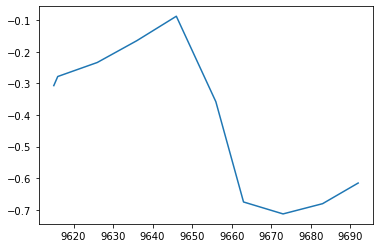

In [78]:
# work_df[work_df.event_name == "20191007_FIRE_sm-s-mobo-c"].air_temp_set_1.plot()
# work_df[work_df.event_name == "20210209_FIRE_hp-e-mobo-c"].air_temp_set_1.plot()
plt.show()

In [86]:
p (len(list(work_df.event_name.unique())) * 9) # 9 = shape of weather tensor + image_prob
work_df.pivot(index=["datetime"], columns="event_name", values=weather_df.columns[1:-1].to_list() + ["image_prob"]).shape[1]

1116

In [78]:
unique_events = work_df.event_name.unique()
select_cols = ["image_prob"] + weather_cols

sequences = []
series_length = 2
lengths = []

for event in unique_events:
    subset = work_df.loc[work_df.event_name == event][select_cols].to_numpy()
    sequences.append(subset)
    lengths.append(subset.shape[0])

In [79]:
pd.Series(lengths).describe()

count    124.000000
mean      78.161290
std        6.296711
min       41.000000
25%       78.000000
50%       81.000000
75%       81.000000
max       81.000000
dtype: float64

In [82]:
len(sequences)
sequences[0].shape

(81, 9)

In [83]:
#Padding the sequence with the values in last row to max length
to_pad = 81
new_seq = []
for one_seq in sequences:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
   
    n_features = 9
    to_concat = np.repeat(one_seq[-1], n).reshape(n_features, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq = np.stack(new_seq)

In [ ]:
train_seq, test_seq = train_test_split(
    final_seq,
    test_size=0.2
)

In [89]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [87]:
model = Sequential()
model.add(LSTM(256, input_shape=(to_pad, n_features)))
model.add(Dense(1, activation='sigmoid'))

In [88]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               272384    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 272,641
Trainable params: 272,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(train, train_target, epochs=200, batch_size=128, callbacks=[chk], validation_data=(validation,validation_target))

In [ ]:
#loading the model and checking accuracy on the test data
model = load_model('best_model.pkl')

from sklearn.metrics import accuracy_score
test_preds = model.predict_classes(test)
accuracy_score(test_target, test_preds)

In [74]:
work_df.columns

Index(['filepath', 'image_pred', 'image_prob', 'type', 'image_gt', 'time',
       'datetime', 'event_name', 'image_name', 'air_temp_set_1',
       'relative_humidity_set_1', 'wind_speed_set_1', 'wind_gust_set_1',
       'wind_direction_set_1', 'dew_point_temperature_set_1d', 'u', 'v',
       'fire_name'],
      dtype='object')

In [80]:
work_df

,filepath,image_pred,image_prob,type,image_gt,time,datetime,event_name,image_name,air_temp_set_1,relative_humidity_set_1,wind_speed_set_1,wind_gust_set_1,wind_direction_set_1,dew_point_temperature_set_1d,u,v,fire_name
0,20191007_FIRE_sm-s-mobo-c/1570473811_-02400,0,0.040000,valid,0,1570473811,2019-10-07 18:43:31+00:00,20191007_FIRE_sm-s-mobo-c,20191007_FIRE_sm-s-mobo-c/1570473811_-02400,0.893400,-0.757200,-0.3918,-0.424200,0.101620,-0.270600,0.106052,0.181328,20191007_FIRE_sm-s-mobo-c
1,20191007_FIRE_sm-s-mobo-c/1570473871_-02340,0,0.040000,valid,0,1570473871,2019-10-07 18:44:31+00:00,20191007_FIRE_sm-s-mobo-c,20191007_FIRE_sm-s-mobo-c/1570473871_-02340,0.899486,-0.752829,-0.3378,-0.383057,0.102696,-0.258343,0.122988,0.194355,20191007_FIRE_sm-s-mobo-c
2,20191007_FIRE_sm-s-mobo-c/1570473931_-02280,0,0.050000,valid,0,1570473931,2019-10-07 18:45:31+00:00,20191007_FIRE_sm-s-mobo-c,20191007_FIRE_sm-s-mobo-c/1570473931_-02280,0.905571,-0.748457,-0.2838,-0.341914,0.103772,-0.246086,0.139923,0.207381,20191007_FIRE_sm-s-mobo-c
3,20191007_FIRE_sm-s-mobo-c/1570473991_-02220,0,0.040000,valid,0,1570473991,2019-10-07 18:46:31+00:00,20191007_FIRE_sm-s-mobo-c,20191007_FIRE_sm-s-mobo-c/1570473991_-02220,0.911657,-0.744086,-0.2298,-0.300771,0.104848,-0.233829,0.156859,0.220408,20191007_FIRE_sm-s-mobo-c
4,20191007_FIRE_sm-s-mobo-c/1570474051_-02160,0,0.230000,valid,0,1570474051,2019-10-07 18:47:31+00:00,20191007_FIRE_sm-s-mobo-c,20191007_FIRE_sm-s-mobo-c/1570474051_-02160,0.917743,-0.739714,-0.1758,-0.259629,0.105924,-0.221571,0.173794,0.233435,20191007_FIRE_sm-s-mobo-c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9688,20210209_FIRE_hp-e-mobo-c/1612895127_+02160,1,0.999512,test,1,1612895127,2021-02-09 18:25:27+00:00,20210209_FIRE_hp-e-mobo-c,20210209_FIRE_hp-e-mobo-c/1612895127_+02160,-0.644700,0.280800,0.4266,0.242100,1.177603,0.180900,0.648204,-0.274039,20210209_FIRE_hp-e-mobo-c
9689,20210209_FIRE_hp-e-mobo-c/1612895187_+02220,1,0.999512,test,1,1612895187,2021-02-09 18:26:27+00:00,20210209_FIRE_hp-e-mobo-c,20210209_FIRE_hp-e-mobo-c/1612895187_+02220,-0.637440,0.275760,0.4332,0.238320,1.264287,0.181920,0.651422,-0.276253,20210209_FIRE_hp-e-mobo-c
9690,20210209_FIRE_hp-e-mobo-c/1612895247_+02280,1,0.999512,test,1,1612895247,2021-02-09 18:27:27+00:00,20210209_FIRE_hp-e-mobo-c,20210209_FIRE_hp-e-mobo-c/1612895247_+02280,-0.630180,0.270720,0.4398,0.234540,1.350971,0.182940,0.654641,-0.278467,20210209_FIRE_hp-e-mobo-c
9691,20210209_FIRE_hp-e-mobo-c/1612895307_+02340,1,0.999512,test,1,1612895307,2021-02-09 18:28:27+00:00,20210209_FIRE_hp-e-mobo-c,20210209_FIRE_hp-e-mobo-c/1612895307_+02340,-0.622920,0.265680,0.4464,0.230760,1.437655,0.183960,0.657859,-0.280681,20210209_FIRE_hp-e-mobo-c
